In [1]:
import pandas as pd
import requests
import datetime as dt
import matplotlib.pyplot as plt

# URL for the USGS FDSN web service
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Parameters for the query
params = {
    "format": "geojson",
    "starttime": "2023-01-01",
    "endtime": "2023-12-31",
    "minmagnitude": 4.5,
}

# Send the request to the USGS FDSN web service
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the GeoJSON data
    earthquake_data = response.json()
    
    # Print some information about the data
    print("Number of earthquakes:", len(earthquake_data["features"]))
    print("First earthquake:", earthquake_data["features"][0])

    # Extract the desired information and properties
    earthquake_list = []
    for feature in earthquake_data["features"]:
        earthquake = {
            "type": feature["type"],
            "geometry": feature["geometry"],
            "id": feature["id"]
        }
        # Add properties to the earthquake dictionary
        for key, value in feature["properties"].items():
            earthquake[key] = value

        earthquake_list.append(earthquake)

    # Create a DataFrame
    df = pd.DataFrame(earthquake_list)
    
    # Print the geometry column before transformation
    print("Geometry column before transformation:")
    print(df['geometry'].head())

    # Extract latitude, longitude, and depth from the 'geometry' column
    df['latitude'] = df['geometry'].apply(lambda x: x['coordinates'][1])
    df['longitude'] = df['geometry'].apply(lambda x: x['coordinates'][0])
    df['depth'] = df['geometry'].apply(lambda x: x['coordinates'][2])

    # Drop the 'geometry' column if it's no longer needed
    df.drop(columns=['geometry'], inplace=True)

    # Print the updated DataFrame to validate changes
    print("Updated Earthquake DataFrame (first 5 rows):")
    print(df.head())

    # Save the DataFrame to a CSV file
    df.to_csv('earthquake_data.csv', index=False)
    print("Data has been saved to earthquake_data.csv")

else:
    print("Error:", response.status_code)


Number of earthquakes: 7638
First earthquake: {'type': 'Feature', 'properties': {'mag': 4.6, 'place': 'central East Pacific Rise', 'time': 1703979250971, 'updated': 1709415574040, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us6000m0qq', 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000m0qq&format=geojson', 'felt': None, 'cdi': None, 'mmi': None, 'alert': None, 'status': 'reviewed', 'tsunami': 0, 'sig': 326, 'net': 'us', 'code': '6000m0qq', 'ids': ',us6000m0qq,', 'sources': ',us,', 'types': ',origin,phase-data,', 'nst': 63, 'dmin': 21.509, 'rms': 0.63, 'gap': 160, 'magType': 'mb', 'type': 'earthquake', 'title': 'M 4.6 - central East Pacific Rise'}, 'geometry': {'type': 'Point', 'coordinates': [-102.9478, -3.6423, 10]}, 'id': 'us6000m0qq'}
Geometry column before transformation:
0    {'type': 'Point', 'coordinates': [-102.9478, -...
1    {'type': 'Point', 'coordinates': [147.1624, -6...
2    {'type': 'Point', 'coordinates': [17.9273, 44..

In [2]:
#Convert Timestamp to Datetime and Extract Features:
df['time'] = pd.to_datetime(df['time'], unit='ms')
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute

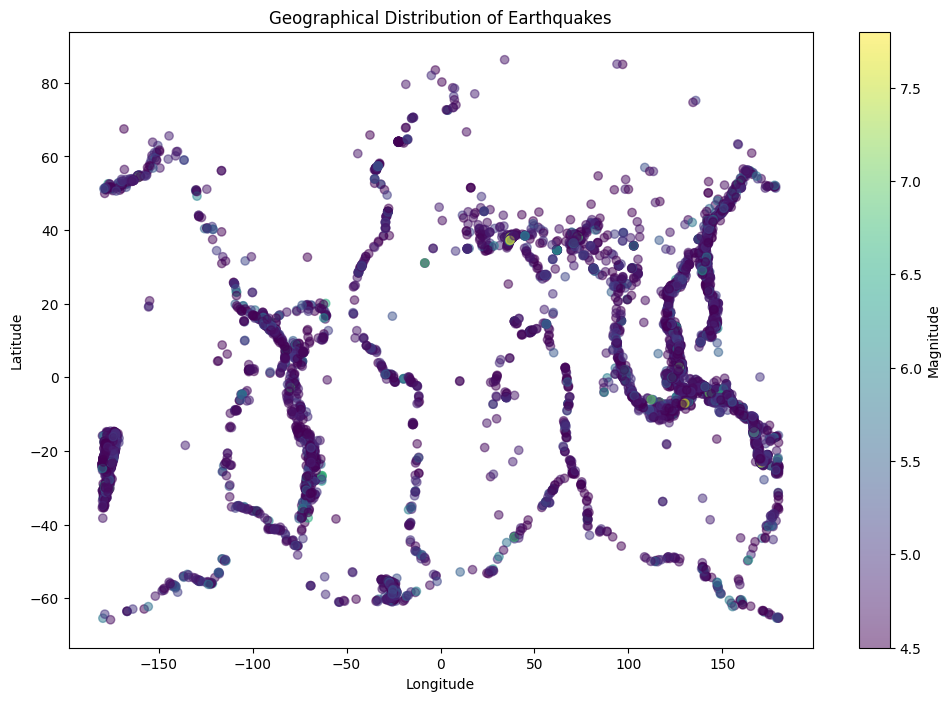

Mean Squared Error: 0.13404037984293202
R-squared: 0.02755691783030212


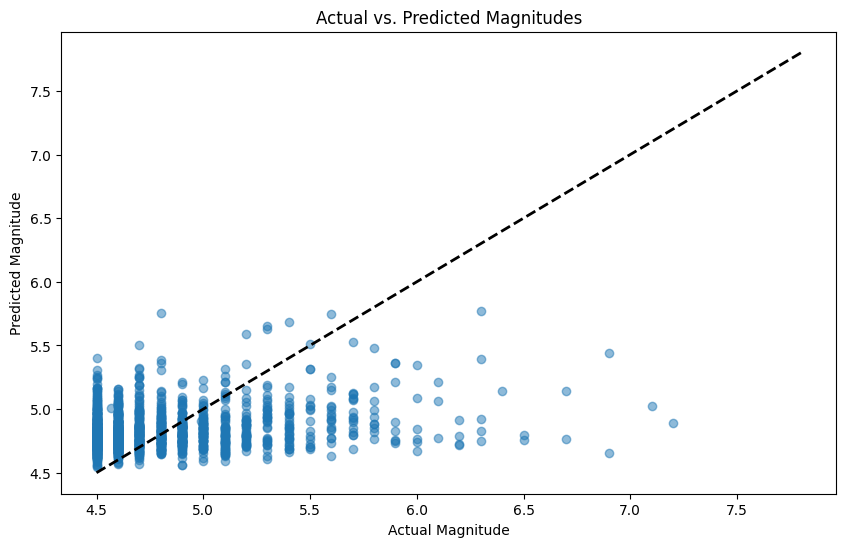

In [3]:
import matplotlib.pyplot as plt

# Scatter plot of earthquake locations
plt.figure(figsize=(12, 8))
plt.scatter(df['longitude'], df['latitude'], alpha=0.5, c=df['mag'], cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of Earthquakes')
plt.show()

# Plot actual vs. predicted magnitudes if you're working on a model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target variable
X = df[['latitude', 'longitude', 'depth', 'year', 'month', 'day', 'hour', 'minute']]
y = df['mag']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Actual vs. Predicted Magnitudes')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Add a line y=x for reference
plt.show()


Mean Squared Error: 0.1280703738495799
R-squared: 0.07086842616495292


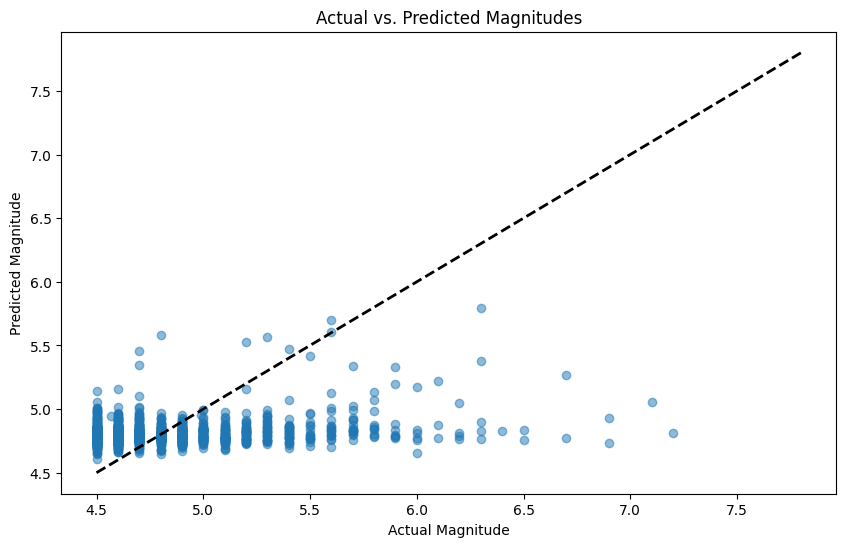

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define features and target variable
X = df[['latitude', 'longitude', 'depth', 'year', 'month', 'day', 'hour', 'minute']]
y = df['mag']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Visualize Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Actual vs. Predicted Magnitudes')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Add a line y=x for reference
plt.show()
